'sample_data/assets_correlation_heatmap.png'

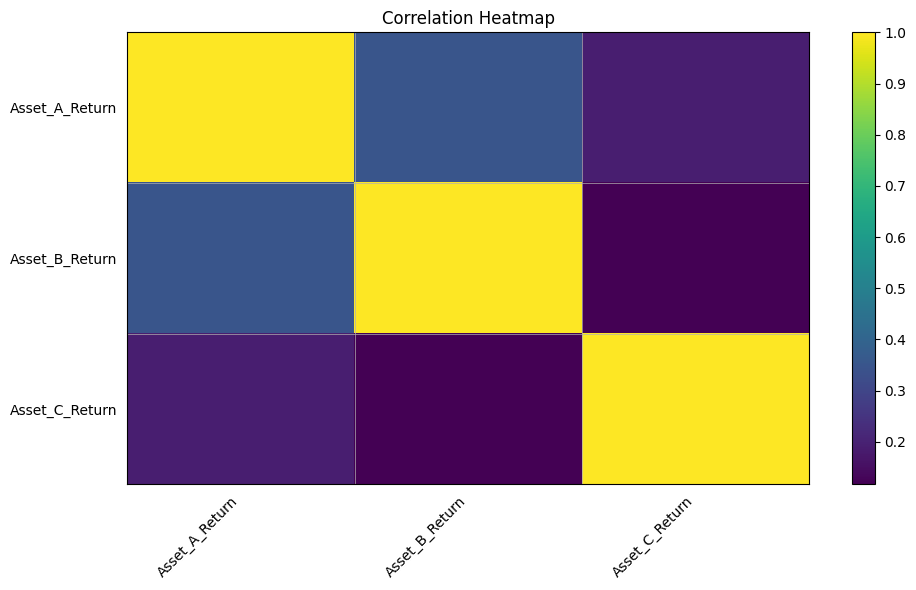

In [3]:
# Generate a correlation heatmap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# ---- Load returns ----
returns = pd.read_csv("sample_data/3assets_returns.csv", index_col=0, parse_dates=True)

# Compute correlation matrix
corr = returns.corr()

# ---- Plot heatmap (matplotlib, no seaborn, single plot, no explicit colors) ----
fig, ax = plt.subplots(figsize=(10, 6))
im = ax.imshow(corr.values, aspect="auto")

# Ticks and labels
ax.set_xticks(np.arange(corr.shape[1]))
ax.set_yticks(np.arange(corr.shape[0]))
ax.set_xticklabels(corr.columns, rotation=45, ha="right")
ax.set_yticklabels(corr.index)

# Title
ax.set_title("Correlation Heatmap")

# Colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.ax.set_ylabel("", rotation=90, va="bottom")

# Grid lines (optional, keep subtle)
ax.set_xticks(np.arange(-0.5, corr.shape[1], 1), minor=True)
ax.set_yticks(np.arange(-0.5, corr.shape[0], 1), minor=True)
ax.grid(which="minor", linestyle="-", linewidth=0.5)
ax.tick_params(which="both", bottom=False, left=False)

plt.tight_layout()
out_path = "sample_data/assets_correlation_heatmap.png"
plt.savefig(out_path, dpi=200, bbox_inches="tight")


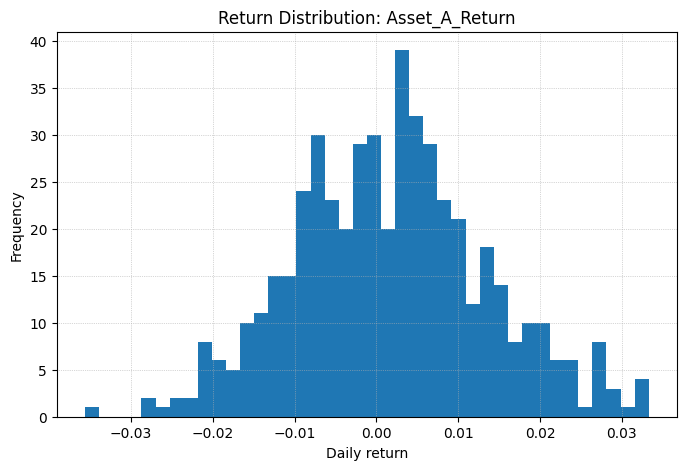

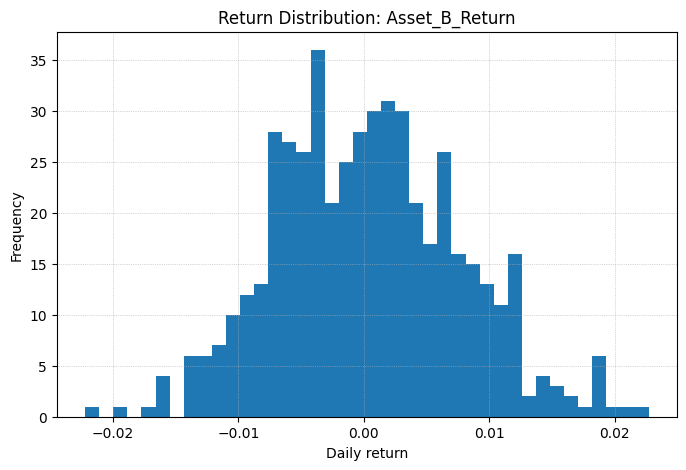

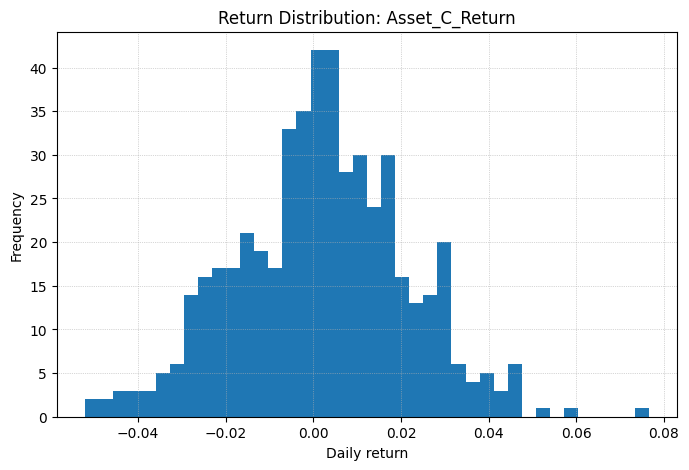

In [4]:


# Histogram per asset
for col in returns.columns:
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.hist(returns[col].dropna().values, bins=40)
    ax.set_title(f"Return Distribution: {col}")
    ax.set_xlabel("Daily return")
    ax.set_ylabel("Frequency")
    ax.grid(True, linestyle=":", linewidth=0.5)
    fig.savefig(f"return_distribution_{col}.png", dpi=200, bbox_inches="tight")
    plt.show()


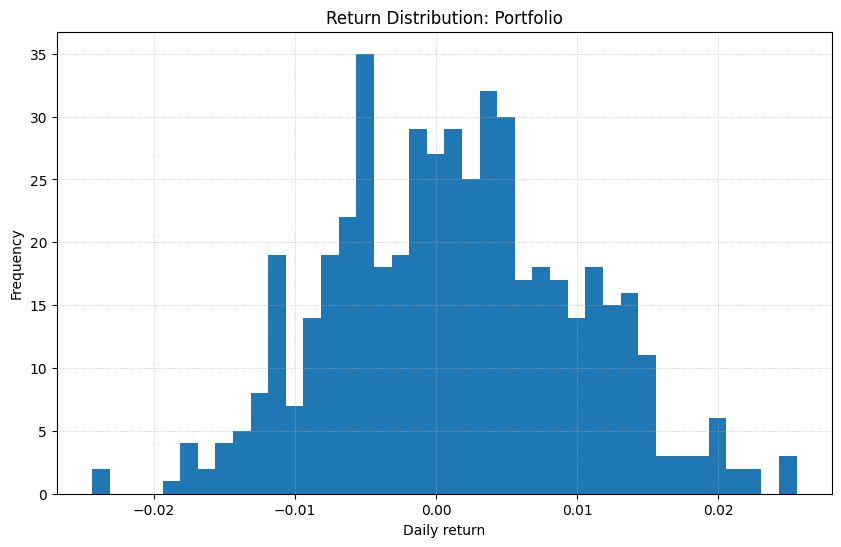

In [6]:
# Generate a histogram of weighted portfolio daily returns using provided weights and uploaded returns file.

# Weights: A=50%, B=30%, C=20%
weights = np.array([0.5, 0.3, 0.2])

# Ensure column order matches A, B, C (rename if necessary)
cols = list(returns.columns)
assert len(cols) == 3, f"Expected 3 assets, found {len(cols)}: {cols}"

# Compute weighted portfolio returns
port_ret = returns.values @ weights

# Plot histogram
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(port_ret, bins=40)  # default color/style per tool guidance
ax.set_title("Return Distribution: Portfolio")
ax.set_xlabel("Daily return")
ax.set_ylabel("Frequency")
ax.grid(True, linestyle=":", linewidth=0.5)

out_path = "sample_data/portfolio_return_distribution.png"
fig.savefig(out_path, dpi=200, bbox_inches="tight")



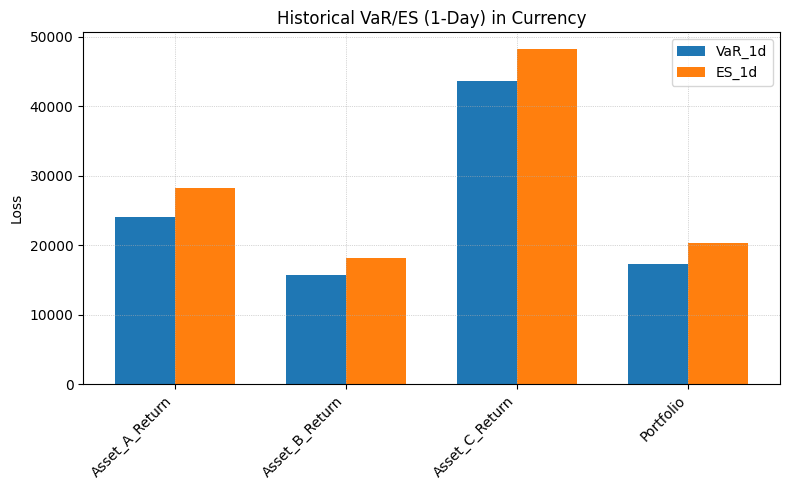

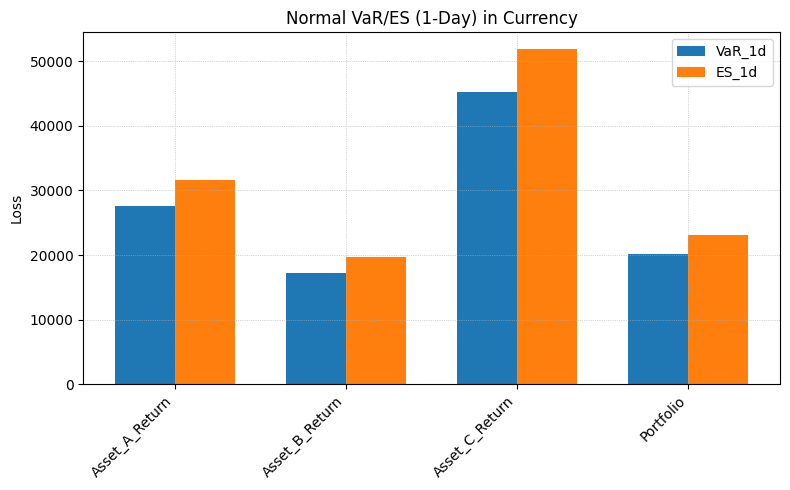

In [8]:
from scipy.stats import norm

# Params
CL = 0.99
z = 2.3263478740408408
total_value = 1_000_000.0
weights = np.array([0.5, 0.3, 0.2])


assets = list(returns.columns)

# --- Empirical (Historical) VaR/ES ---
def var_es_empirical(ret, cl=CL, notional=total_value):
    losses = -ret * notional
    var = float(np.percentile(losses, cl*100))
    es  = float(losses[losses >= var].mean())
    return var, es

hist_rows = []
for col in assets:
    v, e = var_es_empirical(returns[col].values)
    hist_rows.append((col, v, e))
port_ret = returns.values @ weights
v_p, e_p = var_es_empirical(port_ret)
hist_rows.append(("Portfolio", v_p, e_p))
hist_df = pd.DataFrame(hist_rows, columns=["Name","VaR_1d","ES_1d"]).set_index("Name")

# --- Normal (Parametric) VaR/ES ---
k = norm.pdf(z) / (1-CL)
sigma_assets = returns.std(ddof=1)
var_norm_assets = z * sigma_assets * total_value
es_norm_assets  = k * sigma_assets * total_value
cov = returns.cov().values
sigma_port = float(np.sqrt(weights @ cov @ weights.T))
var_norm_port = z * sigma_port * total_value
es_norm_port  = k * sigma_port * total_value
norm_df = pd.DataFrame({
    "VaR_1d": list(var_norm_assets.values) + [var_norm_port],
    "ES_1d":  list(es_norm_assets.values)  + [es_norm_port],
}, index=assets + ["Portfolio"])

# --- Plot: Historical ---
fig1, ax1 = plt.subplots(figsize=(8,5))
x = np.arange(len(hist_df))
w = 0.35
ax1.bar(x-w/2, hist_df["VaR_1d"], w, label="VaR_1d")
ax1.bar(x+w/2, hist_df["ES_1d"],  w, label="ES_1d")
ax1.set_xticks(x); ax1.set_xticklabels(hist_df.index, rotation=45, ha="right")
ax1.set_ylabel("Loss"); ax1.set_title("Historical VaR/ES (1-Day) in Currency")
ax1.grid(True, linestyle=":", linewidth=0.5); ax1.legend()
plt.tight_layout(); plt.savefig("historical_var_es_1d.png", dpi=200, bbox_inches="tight")

# --- Plot: Normal ---
fig2, ax2 = plt.subplots(figsize=(8,5))
x = np.arange(len(norm_df))
ax2.bar(x-w/2, norm_df["VaR_1d"], w, label="VaR_1d")
ax2.bar(x+w/2, norm_df["ES_1d"],  w, label="ES_1d")
ax2.set_xticks(x); ax2.set_xticklabels(norm_df.index, rotation=45, ha="right")
ax2.set_ylabel("Loss"); ax2.set_title("Normal VaR/ES (1-Day) in Currency")
ax2.grid(True, linestyle=":", linewidth=0.5); ax2.legend()
plt.tight_layout(); plt.savefig("normal_var_es_1d.png", dpi=200, bbox_inches="tight")
plt.show()


In [14]:
# Liquidity Waterfall (L-VaR) chart based on given parameters

# ---------------- Parameters ----------------
CL = 0.99
z = 2.3263478740408408
total_value = 1_000_000.0
weights = np.array([0.5, 0.3, 0.2])

halfspread_bps = np.array([10, 15, 8])  # bps
ttl_days = 3
impact_bps = np.array([5, 8, 4])

# ---------------- Load returns ----------------
# returns = pd.read_csv("/mnt/data/3assets_returns.csv", index_col=0, parse_dates=True)
assets = list(returns.columns)

# ---------------- Base 1d Normal VaR (portfolio) ----------------
cov = returns.cov().values
sigma_p = float(np.sqrt(weights @ cov @ weights.T))
base_var_1d = z * sigma_p * total_value

# ---------------- Liquidity Add-ons ----------------
values = total_value * weights
# Spread add-on
spread_addons = (halfspread_bps/1e4) * values * np.sqrt(ttl_days)
# Impact add-on
impact_addons = (impact_bps/1e4) * values * np.sqrt(ttl_days)

spread_total = float(spread_addons.sum())
impact_total = float(impact_addons.sum())
liq_total = spread_total + impact_total

# ---------------- LVaR ----------------
lvar_total = base_var_1d + liq_total

# ---------------- Waterfall chart ----------------
steps = ["Base VaR (Normal 1d)", "Half-Spread + √TTL", "Impact", "LVaR Total"]
losses = [base_var_1d, spread_total, impact_total, lvar_total]

fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar(steps, losses)
ax.set_ylabel("Loss")
ax.set_title("Liquidity Waterfall (Currency)")
ax.grid(True, linestyle=":", linewidth=0.5, axis="y")

out_path = "sample_data/liquidity_waterfall.png"
fig.savefig(out_path, dpi=200, bbox_inches="tight")
plt.close(fig)

print(f"base_var_1d   : {base_var_1d} , \n spread_total : {spread_total}, \n impact_total : {impact_total}, \n lvar_total : {lvar_total}")


base_var_1d   : 20187.010280538852 , 
 spread_total : 1922.5763964014536, 
 impact_total : 987.2689603142599, 
 lvar_total : 23096.855637254564
